In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import glob
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

import copy
from astropy.visualization import quantity_support
from astropy.table import Table, QTable
import matplotlib
import astropy.units as u
from astroduet.config import Telescope
from astroduet.background import background_pixel_rate
font = {'size'   : 22}
from astroduet.models import Simulations, fits_file, load_model_ABmag, load_model_fluence
matplotlib.rc('font', **font)
from astroduet.lightcurve import get_lightcurve, lightcurve_through_image
import astroduet.image_utils
import seaborn as sns


In [2]:
# # Do it only once
# sims = Simulations()
# sims.parse_emgw()

In [3]:
def create_and_plot_lc(input_lc_file, distance=100e6*u.pc, **kwargs):
    abtime, ab1, ab2 = load_model_ABmag(input_lc_file,
                                        dist=distance)
    model_lc_table_ab = QTable({'time': abtime, 'mag_D1': ab1, 'mag_D2':ab2})
    lightcurve = get_lightcurve(input_lc_file, distance=distance, **kwargs)
    plt.figure(figsize=(15, 8))
    gs = plt.GridSpec(2, 1, hspace=0)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1], sharex=ax0)
    good = (lightcurve['snr_D1'] > 1) | (lightcurve['snr_D2'] > 1)
    lightcurve = lightcurve[good]
    ax0.errorbar(lightcurve['time'].value / 86400, lightcurve['mag_D1'].value, 
                 fmt='o', markersize=2, yerr=lightcurve['mag_D1_err'].value)
    ax0.errorbar(lightcurve['time'].value / 86400, lightcurve['mag_D2'].value, 
                 fmt='o', markersize=2, yerr=lightcurve['mag_D2_err'].value)
    ax1.scatter(lightcurve['time'].value / 86400, lightcurve['snr_D1'].value, s=2)
    ax1.scatter(lightcurve['time'].value / 86400, lightcurve['snr_D2'].value, s=2)
    
    ax0.plot(model_lc_table_ab['time'] / 86400, model_lc_table_ab[f'mag_D1'])
    ax0.plot(model_lc_table_ab['time'] / 86400, model_lc_table_ab[f'mag_D2'])

    ax0.set_ylabel("AB mag")
    ax1.set_ylabel("S/R")
    ax1.set_xlabel("Time (d)")
    ax0.set_xlim([lightcurve['time'][0].value / 86400, lightcurve['time'][-1].value / 86400])
    ymin = min(lightcurve['mag_D1'].value.min(), lightcurve['mag_D2'].value.min()) - 1
    ymax = max(lightcurve['mag_D1'].value.max(), lightcurve['mag_D2'].value.max()) + 1
    # Inverted ax for magnitude
#     ax0.set_ylim([ymax, ymin])
#    ax1.semilogx();
    

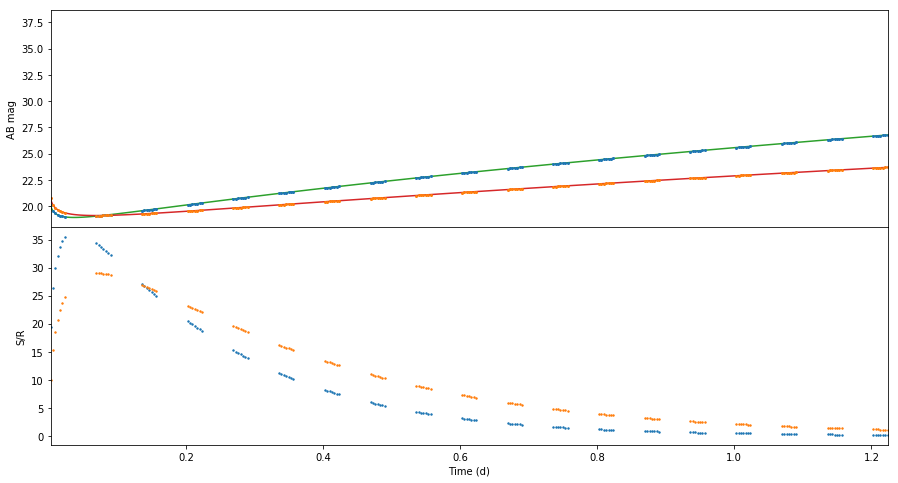

In [4]:
create_and_plot_lc('shock_2.5e10.dat', distance=100e6*u.pc)

Now specifying the observing window...

In [5]:
def plot_realistic_lightcurve(input_lc_file, exposure, label=None, debug=False,  
                              observing_windows=np.array([[0, 30000]]) * u.s, 
                              final_resolution=1200 * u.s, distance=150e6*u.pc):
    # Set debug to True to dump all intermediate images.
    lightcurve_init = \
        get_lightcurve(input_lc_file, exposure=exposure, observing_windows=observing_windows,
                       distance=distance)
    lightcurve_rebin = lightcurve_through_image(lightcurve_init, exposure=exposure, 
                                                final_resolution=final_resolution, 
                                                debug=debug)
    lightcurve = lightcurve_through_image(lightcurve_init, exposure=exposure, debug=debug)
    
    model_lc_table_fl = QTable(load_model_fluence(input_lc_file,
                                                  dist=distance))

    plt.figure(figsize=(15, 10))
    plt.plot(model_lc_table_fl['time'].value / 86400, 
             model_lc_table_fl['fluence_D1'].to(u.ph / u.cm**2 / u.s).value, label=f"init D1",
             color='r')
    plt.plot(model_lc_table_fl['time'].value / 86400, 
             model_lc_table_fl['fluence_D2'].to(u.ph / u.cm**2 / u.s).value, label=f"init D2",
             color='b')
    
    for lc, expo in zip([lightcurve, lightcurve_rebin], [exposure, final_resolution]):
        alpha = 1
        size = 10
        if expo == exposure:
            alpha = 0.3
            size = 5
        good1 = (lc['fluence_D1_fit'] > 0)&(lc['fluence_D1_fiterr'] < lc['fluence_D1_fit'])
        good2 = (lc['fluence_D2_fit'] > 0)&(lc['fluence_D2_fiterr'] < lc['fluence_D2_fit'])
        good = good1&good2
        plt.errorbar(lc['time'].value[good] / 86400, 
                     lc['fluence_D1_fit'][good].value, 
                     yerr=lc['fluence_D1_fiterr'][good].value, fmt='o', label=f"D1, {expo}",
                     alpha=alpha, color='r', markersize=size)
        plt.errorbar(lc['time'].value[good] / 86400, 
                     lc['fluence_D2_fit'][good].value, 
                     yerr=lc['fluence_D2_fiterr'][good].value, fmt='s', label=f"D2, {expo}",
                     alpha=alpha, color='b', markersize=size)
    plt.xlabel("Time (d)")
    plt.ylabel("Fluence (ph / cm^2 / s)")
    plt.xlim([lightcurve['time'].value.min()/86400, 
              lightcurve['time'].value.max()/86400])
    plt.title(label)
    plt.legend()


  1%|          | 1/112 [00:00<00:12,  9.17it/s]

INFO: Creating images [astroduet.lightcurve]


  0%|          | 0/15 [00:00<?, ?it/s]

INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
  1%|          | 1/112 [00:00<00:11,  9.76it/s]

INFO: Creating images [astroduet.lightcurve]


  0%|          | 0/112 [00:00<?, ?it/s]

INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


100%|██████████| 112/112 [00:30<00:00,  3.71it/s]


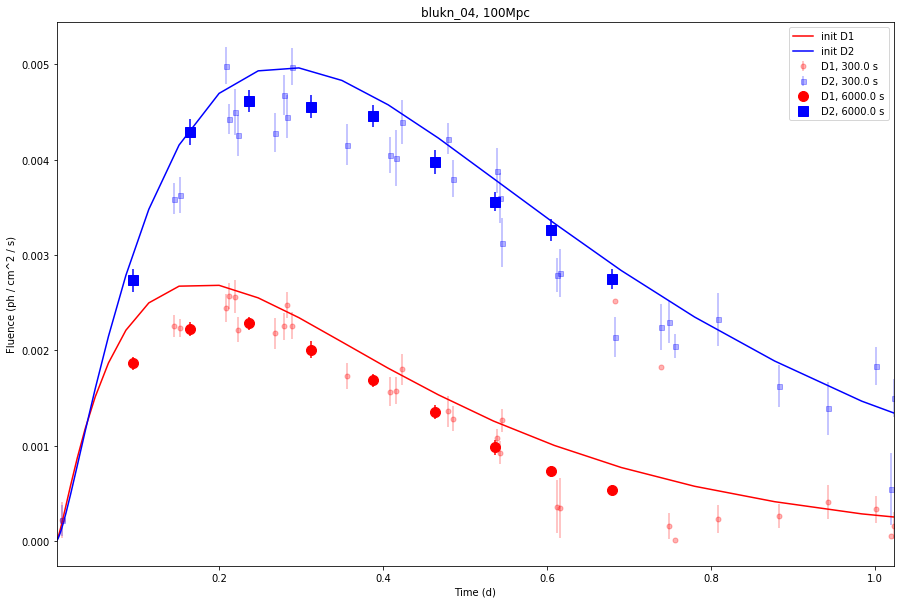

In [9]:
plot_realistic_lightcurve("kilonova_0.04.dat", 300 * u.s,  
                          observing_windows=np.array([[0, 90000]]) * u.s, 
                          final_resolution=6000 * u.s, 
                          distance=100e6*u.pc, label="blukn_04, 100Mpc", debug=True)

In [10]:
## In case someone wants to take a look at the debug images...
## set debug=True in plot_realistic_lightcurves and look at them

def plot_debug_images(directory):
    from astroduet.image_utils import find, run_daophot
    img_pickles = glob.glob(os.path.join(directory, '*.p'))
    for img_pickle in img_pickles:
        with open(img_pickle, 'rb') as fobj:
            img = pickle.load(fobj)
        image1 = img['imgD1']
 
        plt.figure(figsize=(10, 10))
        plt.title(img_pickle)
        plt.imshow(image1.value)
    
# plot_debug_images('debug_imgs_300.0s_12161320/')



/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
  1%|          | 1/112 [00:00<00:11,  9.42it/s]

INFO: Creating images [astroduet.lightcurve]


  0%|          | 0/32 [00:00<?, ?it/s]

INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


100%|██████████| 32/32 [00:07<00:00,  4.24it/s]
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
  1%|          | 1/112 [00:00<00:12,  8.67it/s]

INFO: Creating images [astroduet.lightcurve]


  0%|          | 0/112 [00:00<?, ?it/s]

INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


100%|██████████| 112/112 [00:26<00:00,  4.24it/s]


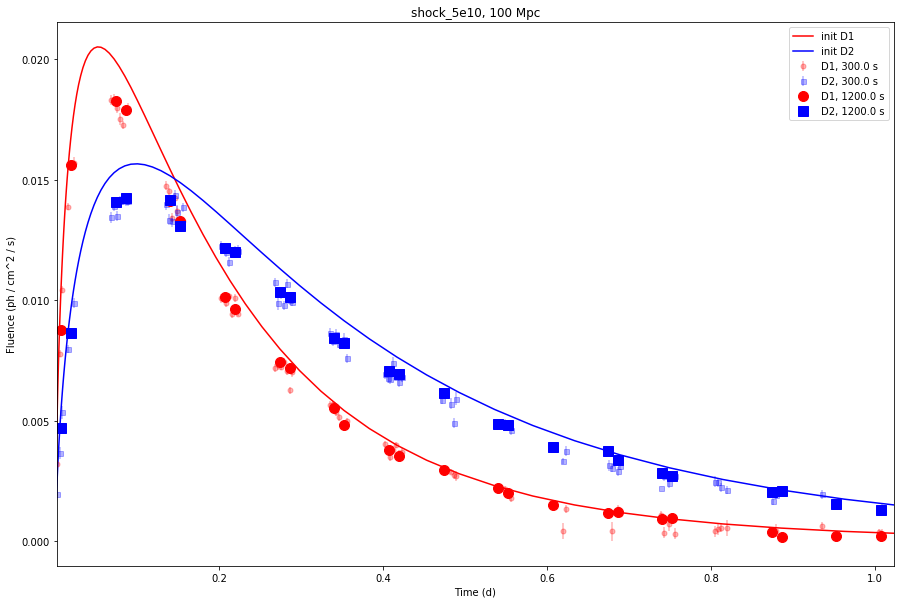

In [11]:
plot_realistic_lightcurve("shock_5e10.dat", exposure=300 * u.s,
                   observing_windows=np.array([[0, 90000]]) * u.s, 
                   distance=100e6*u.pc, 
                   label='shock_5e10, 100 Mpc', debug=False)


In [74]:
def red_chi_sq(f, x, s, dof=None):
    if dof is None:
        dof = len(f) - 1
    return np.sum((f - x)**2 / s**2) / dof


def fit_lightcurve(lightcurve, label='lightcurve fit', solutions=None,
                   debug=False):
    from astroduet.models import Simulations
    from scipy.optimize import curve_fit
    from scipy.interpolate import interp1d
    from astropy.visualization import quantity_support
    quantity_support()
    fluence_D1 = lightcurve['fluence_D1_fit']
    fluence_D2 = lightcurve['fluence_D2_fit']
    good = (fluence_D1 > 0)&(fluence_D2 > 0)
    
    lightcurve = lightcurve[good]
    if len(lightcurve) < 2:
        print("Lightcurve is invalid")
        return solutions
    
    fluence_D1 = lightcurve['fluence_D1_fit']
    fluence_D2 = lightcurve['fluence_D2_fit']
    times = lightcurve['time']
    fluence_D1 = lightcurve['fluence_D1_fit']
    fluence_D2 = lightcurve['fluence_D2_fit']
    fluence_D1_err = lightcurve['fluence_D1_fiterr'] 
    fluence_D2_err = lightcurve['fluence_D2_fiterr'] 

    ratio = fluence_D2 / fluence_D1
    ratio_err = ratio * (fluence_D1_err / fluence_D1 +
                         fluence_D2_err / fluence_D2)

    lc_files = Simulations().emgw_simulations
    if solutions is None:
        solutions = QTable(
            names='model,D1,D2,ratio,D1_chisq,D2_chisq,ratio_chisq'.split(','), 
            dtype=['U30', float, float, float, float, float, float])
    if debug:
        plt.figure(figsize=(15, 15))
        plt.suptitle(label)
        gs = plt.GridSpec(3, 1)
        ax1 = plt.subplot(gs[0])
        ax2 = plt.subplot(gs[1], sharex=ax1)
        axr = plt.subplot(gs[2], sharex=ax1)
        ax1.errorbar(times, fluence_D1, yerr=fluence_D1_err, fmt='o', markersize=5)
        ax2.errorbar(times, fluence_D2, yerr=fluence_D2_err, fmt='o', markersize=5)
        axr.errorbar(times, ratio, yerr=ratio_err, fmt='o', markersize=5)

    for lc_file in lc_files:
        model_lc_table_fl = QTable(load_model_fluence(lc_file))
        interpolated_lc_1 = interp1d(model_lc_table_fl['time'].to(u.s).value,
                           model_lc_table_fl['fluence_D1'].value, fill_value=0,
                           bounds_error=False)
        interpolated_lc_2 = interp1d(model_lc_table_fl['time'].to(u.s).value,
                           model_lc_table_fl['fluence_D2'].value, fill_value=0,
                           bounds_error=False)
        def interpolated_lc_ratio(time):
            return(interpolated_lc_2(time) / interpolated_lc_1(time))
    
        def constant_fit_fun_1(x, a):
            return a * interpolated_lc_1(x)
        def constant_fit_fun_2(x, a):
            return a * interpolated_lc_2(x)
        def constant_fit_fun_ratio(x, a):
            return a * interpolated_lc_ratio(x)
        
        par1, pcov1 = curve_fit(constant_fit_fun_1, 
                                times, fluence_D1, 
                                sigma=fluence_D1_err, p0=[1])
        par2, pcov2 = curve_fit(constant_fit_fun_2, 
                                times, fluence_D2, 
                                sigma=fluence_D2_err, p0=[1])
        parr, pcovr = curve_fit(constant_fit_fun_ratio, 
                                times, ratio, sigma=ratio_err, p0=[1])
        
        d1_chisq = red_chi_sq(constant_fit_fun_1(times, *par1), 
                              fluence_D1.value, fluence_D1_err.value, dof=len(fluence_D1) - 1)
        d2_chisq = red_chi_sq(constant_fit_fun_2(times, *par2), 
                              fluence_D2.value, fluence_D2_err.value, dof=len(fluence_D2) - 1)
        ratio_chisq = red_chi_sq(constant_fit_fun_ratio(times, *parr), 
                              ratio.value, ratio_err.value, dof=len(ratio) - 1)
        
        solutions.add_row({'model': lc_file, 'D1': par1, 'D2': par2, 'ratio': parr, 
                           'D1_chisq': d1_chisq, 'D2_chisq': d2_chisq, 'ratio_chisq': ratio_chisq})
        if debug:
            fine_times = np.linspace(times[0], times[-1], 1000)
            ax1.plot(fine_times, 
                     constant_fit_fun_1(fine_times, *par1), label=lc_file)
            ax2.plot(fine_times, 
                     constant_fit_fun_2(fine_times, *par2), label=lc_file)
            axr.plot(fine_times, 
                     constant_fit_fun_ratio(fine_times, *parr), label=lc_file)
    if debug:
        axr.set_ylabel('Flux ratio')
        ax1.legend()
    return solutions


INFO: Creating images [astroduet.lightcurve]
INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


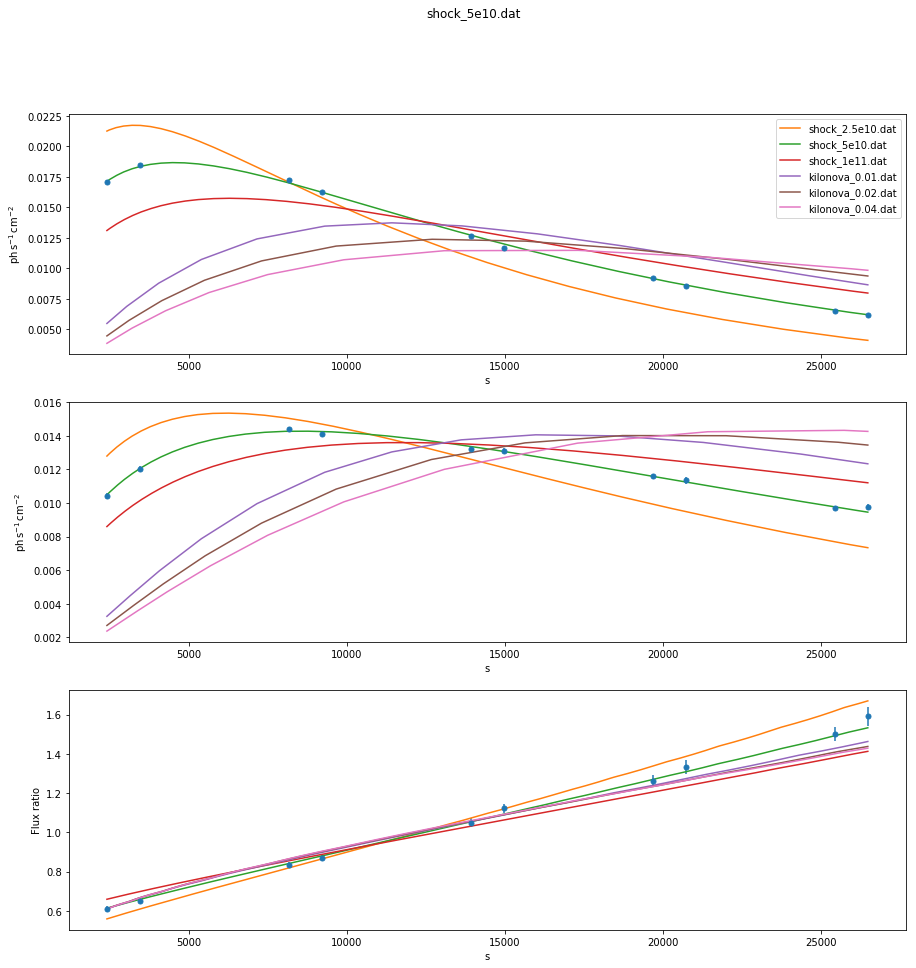

In [75]:
lightcurve_init = \
    get_lightcurve('shock_5e10.dat', exposure=300*u.s,  
                   observing_windows=np.array([[1800, 30000]]) * u.s,
                   distance=100*u.Mpc)
lightcurve_rebin = lightcurve_through_image(lightcurve_init, exposure=300*u.s, 
                                            final_resolution=1200*u.s, 
                                            silent=True)

solutions = fit_lightcurve(lightcurve_rebin, label='shock_5e10.dat', 
                       debug=True)


In [67]:
def get_rebinned_lightcurve_fit(input_lc_file, exposure, label=None, debug=False,  
                            observing_windows=np.array([[1800, 30000]]) * u.s, 
                            final_resolution=1200 * u.s, distance=100e6*u.pc,
                            ntrial=100):
    import seaborn as sns
    import tqdm
    from astroduet.utils import suppress_stdout
    solutions = None
    for i in tqdm.tqdm(range(ntrial)):
        with suppress_stdout():
            lightcurve_init = \
                get_lightcurve(input_lc_file, exposure=exposure, observing_windows=observing_windows,
                               distance=distance)
           
            lightcurve_rebin = lightcurve_through_image(lightcurve_init, exposure=exposure, 
                                                            final_resolution=final_resolution, 
                                                            debug=debug, silent=True)

        solutions = fit_lightcurve(lightcurve_rebin, label=input_lc_file, solutions=solutions,
                                   debug=False)
    return solutions

100%|██████████| 30/30 [03:19<00:00,  6.66s/it]
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


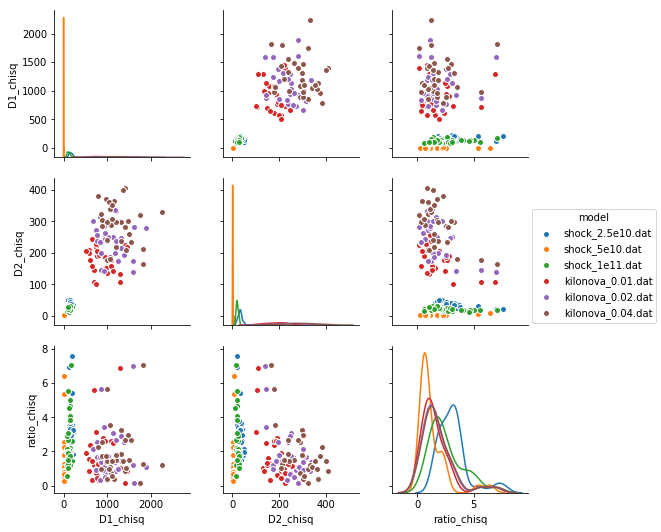

In [64]:
solutions = get_rebinned_lightcurve_fit('shock_5e10.dat', exposure=300 * u.s,
                        observing_windows=np.array([[900, 30000]]) * u.s,
                        distance=150 * u.Mpc, ntrial=30)

sns.pairplot(solutions.to_pandas(), hue='model', diag_kind="kde", vars='D1_chisq,D2_chisq,ratio_chisq'.split(','))


Figure description: The fits with low chi squared are systematically those to the correct model (in this case, a shock-type GRB). We generated 30 light curves corresponding to the model `shock_5e10`, at 150 Mpc, starting 15 minutes after the event, and including all instrumental and zodiacal noise sources, and fitted it with all six GW models. The best-fit on the D1 and D2 light curve (as measured from low values of $\chi^2$) is systematically the one corresponding to the correct model.

 90%|█████████ | 27/30 [02:52<00:19,  6.38s/it]/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:728: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
100%|██████████| 30/30 [03:10<00:00,  6.36s/it]
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, ax

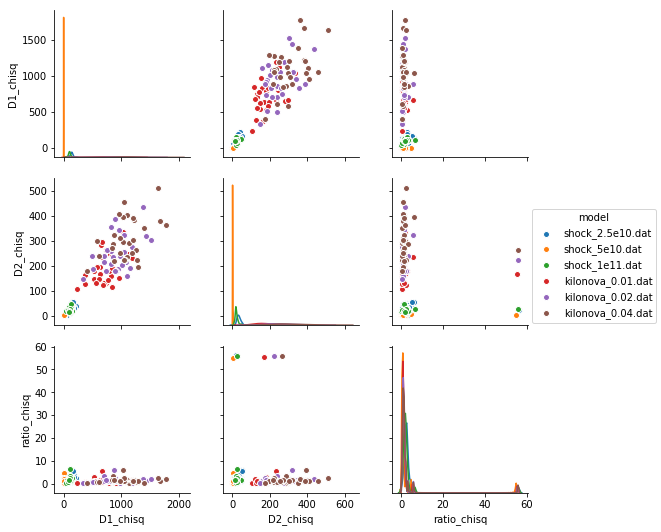

In [70]:
solutions_sh510_30 = get_rebinned_lightcurve_fit('shock_5e10.dat', exposure=300 * u.s,
                        observing_windows=np.array([[1800, 30000]]) * u.s,
                        distance=150 * u.Mpc, ntrial=30)

sns.pairplot(solutions_sh510_30.to_pandas(), hue='model', diag_kind="kde", vars='D1_chisq,D2_chisq,ratio_chisq'.split(','))


Figure description: Same as previous figure, this time starting 30 minutes after the event.

  0%|          | 0/30 [00:00<?, ?it/s]/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:728: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
 10%|█         | 3/30 [00:18<02:48,  6.25s/it]/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:728: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/ipyke

Lightcurve is invalid


/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:728: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
 47%|████▋     | 14/30 [01:28<01:41,  6.33s/it]/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:728: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: d

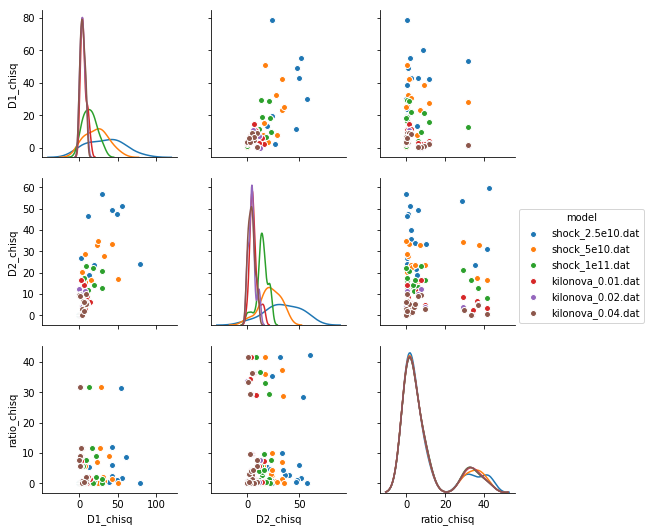

In [69]:
solutions_k04 = get_rebinned_lightcurve_fit('kilonova_0.04.dat', exposure=300 * u.s,
                        observing_windows=np.array([[1800, 30000]]) * u.s,
                       distance=150*u.Mpc, ntrial=30)
sns.pairplot(solutions_k04.to_pandas(), hue='model', diag_kind="kde", vars='D1_chisq,D2_chisq,ratio_chisq'.split(','))


Figure description: Same as previous figure, but this time we simulated 30 lightcurves corresponding to the model `kilonova_0.04`, at 150 Mpc, starting 30 minutes after the event, including all instrumental and zodiacal noise sources, and fitted it with all six GW models. The best-fit on the D1 and D2 light curve (as measured from low values of $\chi^2$), in this case, separates kilonova models from shock GRB models but not much different kilonova models.